# Simulated PDF

In this notebook, I'll run through the steps, coupled with some validation of how to generate a PDF from an event time series.

In [51]:
import sys
sys.path.append("../")

from __init__ import *
from data_tools import *
from testing import *

Below we specify the values for impedance, number of channels, boltzmann constant, bandwidth and number of samples.

We then calculate the noise power, the variance for the time and frequency domain (divided by the number of samples).

In [52]:
R, Nch, kb, bw, Nsamp, T= 496.1709043911709, 1, 1.38e-23, 1000e6, 40960, 5

# R = Impedance
# Nch = No. of channels
# kb = Boltzmann constant
# Nsamp = Number of Samples
# T = Temperature (Kelvin) 

# noise power
n_pwr = kb * T * bw

# noise variance single channel, time-domain (tau_1t)
tau_1t = n_pwr * R

# noise variance single channel, freq-domain (tau_1f)
tau_1f = tau_1t / Nsamp

# single-channel complex wgn with total variance tau_1t
rng = np.random.default_rng()
noise_1t = rng.multivariate_normal([0,0], np.eye(2) * tau_1t/2, Nsamp) # variance is divided by two for correct total variance.
noise_1t = noise_1t[:,0] + 1j * noise_1t[:,1]

print('1 Channel, Time-domain')
print(f'The single-channel time-domain noise variance is --- {tau_1t}')
print(f'The single-channel time-domain sample variance is --- {np.mean(abs(noise_1t)**2)}\n')

noise_1f = np.fft.fft(noise_1t, norm='forward')

print('1 Channel, Freq-domain')
print(f'The single-channel freq-domain noise variance is --- {tau_1f}')
print(f'The single-channel freq-domain sample variance is --- {np.mean(abs(noise_1f)**2)}\n')

1 Channel, Time-domain
The single-channel time-domain noise variance is --- 3.42357924029908e-11
The single-channel time-domain sample variance is --- 3.43385020177236e-11

1 Channel, Freq-domain
The single-channel freq-domain noise variance is --- 8.358347754636425e-16
The single-channel freq-domain sample variance is --- 8.383423344170802e-16



Here we generate some noise and validate that our generation and CDF calculations align.



1000


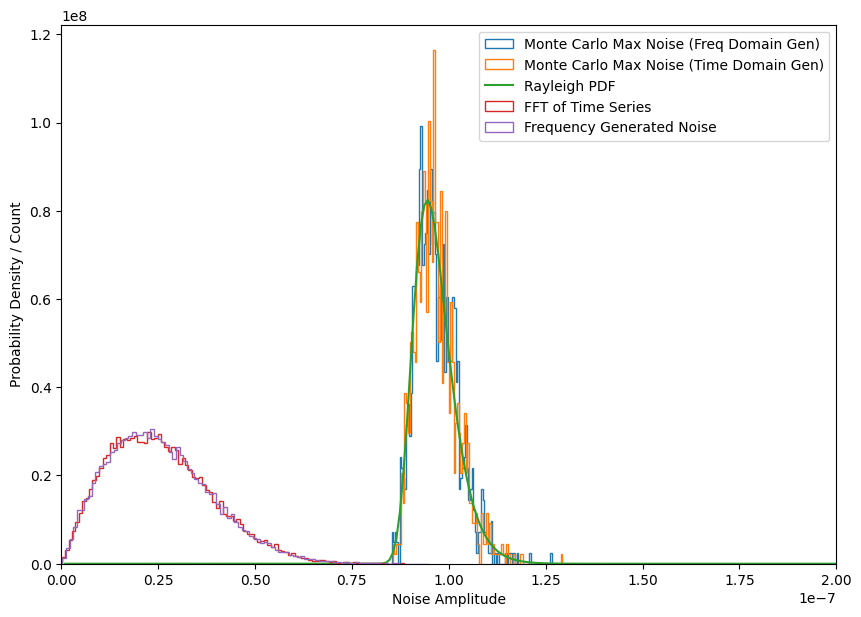

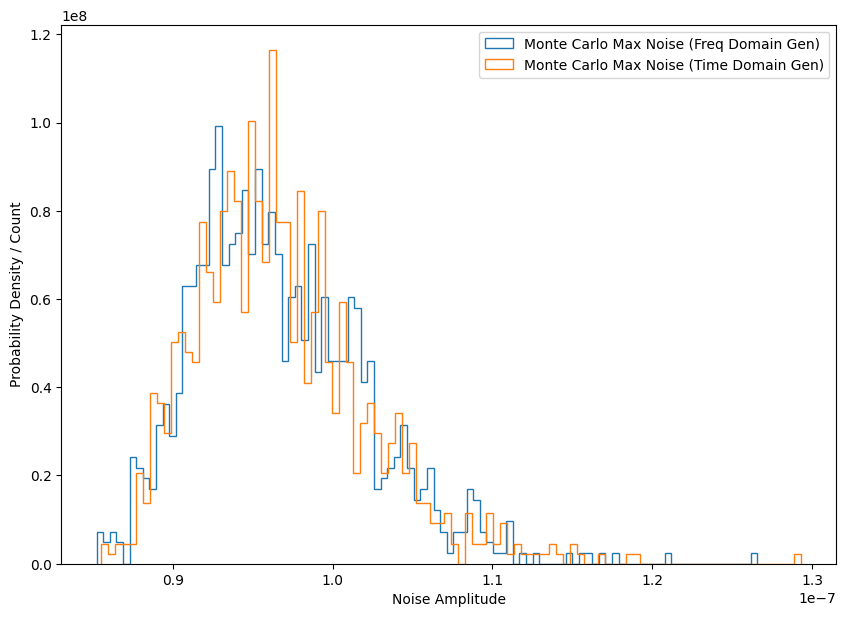

<Figure size 640x480 with 0 Axes>

9.668390265656998e-05
9.674281971469885e-05


In [ ]:

# x = np.linspace(2e-7,5e-7, 1001)
x = np.linspace(1e-9,9e-6, 10001)

ray_cdf = (1-np.exp(-(x**2)/tau_1f)) ** Nsamp
ray_pdf = np.gradient(ray_cdf, x[1]-x[0])

N = 1000

noise = rng.multivariate_normal([0,0],np.eye(2)*tau_1f/2, N*Nsamp) # Generate a 2d gaussian
noise = noise[:,0] + 1j * noise[:,1] # Sample from said Gaussian to get a complex number 
noise = noise.reshape(N, Nsamp) # Reshape the gaussian to be 3d
noise_max = np.max(abs(noise), axis=1) # Take the maximum of the N samples


noise_time = rng.multivariate_normal([0,0],np.eye(2)*tau_1t/2, N*Nsamp) # Generate a 2d gaussian
noise_time = noise_time[:,0] + 1j * noise_time[:,1] # Sample from said Gaussian to get a complex number
noise_time = noise_time.reshape(N, Nsamp) # Reshape the gaussian to be 3d

for i in range(N):
    noise_time[i] = np.fft.fft(noise_time[i], norm='forward')

noise_time_max = np.max(abs(noise_time), axis=1) # Take the maximum of the N samples

noise = noise.flatten()
noise = noise.reshape(Nsamp, N)
noise = noise[:,0]

noise_time = np.random.normal(0, np.sqrt(tau_1t), Nsamp)
noise_FFT = np.fft.fft(noise_time, norm='forward')
noise_freqs = np.fft.fftfreq(Nsamp, 1e-9)

#######################################################

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot()
plt.hist(abs(noise_max), bins=100, density=True, histtype='step', label='Monte Carlo Max Noise (Freq Domain Gen)')
plt.hist(abs(noise_time_max), bins=100, density=True, histtype='step', label='Monte Carlo Max Noise (Time Domain Gen)')
ax.plot(x,  ray_pdf, label='Rayleigh PDF');
ax.set_xlim(0, 0.2e-6)


plt.hist(abs(noise_FFT), bins=100, density=True, histtype='step', label='FFT of Time Series')
plt.hist(abs(noise), bins=100, density=True, histtype='step', label='Frequency Generated Noise')
plt.legend()

plt.ylabel('Probability Density / Count')
plt.xlabel('Noise Amplitude')
plt.show()

# ############################################################################################################


fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot()

plt.hist(abs(noise_max), bins=100, density=True, histtype='step', label='Monte Carlo Max Noise (Freq Domain Gen)')
plt.hist(abs(noise_time_max), bins=100, density=True, histtype='step', label='Monte Carlo Max Noise (Time Domain Gen)')

plt.legend(
)
plt.ylabel('Probability Density / Count')
plt.xlabel('Noise Amplitude')
plt.show()


# fig, axs = plt.subplots(1, 2, figsize=(8,6))
# axs[0].plot(noise_freqs, abs(noise_FFT))
# axs[0].set_xlabel('Frequency (Hz)')
# axs[0].set_ylabel('Noise Amplitude')
# axs[0].set_title('Noise Spectrum')

# time = np.linspace(0, Nsamp, Nsamp)
# axs[1].plot(time, abs(noise))
# axs[1].set_xlabel('Time (s)')
# axs[1].set_ylabel('Noise Amplitude')
# axs[1].set_title('Noise Time Series')

plt.figure()

plt.show()

print(np.sum(abs(noise_max)))
print(np.sum(abs(noise_time_max)))


In [77]:
abs_noise = abs(noise_FFT)
abs_noise_squared = abs(noise_FFT)**2

noise_squared = abs(noise)**2 / Nsamp

print('FFT: ', np.sum(abs_noise_squared))
print('Time: ', np.sum(noise_squared))

FFT:  3.4386912940882854e-11
Time:  3.401613415967308e-11


In [76]:
# noise = rng.multivariate_normal([0,0],np.eye(2)*tau_1t/2, Nsamp) # Generate a 2d gaussian
# noise = noise[:,0] + 1j * noise[:,1] # Sample from said Gaussian to get a complex number 

# gaus1 = np.random.normal(0, np.sqrt(tau_1t/2), Nsamp)
# gaus2 = np.random.normal(0, np.sqrt(tau_1t/2), Nsamp)
# gaus_full = gaus1 + 1j * gaus2

# ray_single_cdf = 1-np.exp(-(x**2)/tau_1t)
# ray_single_pdf = np.gradient(ray_single_cdf, x[1]-x[0])

# plt.hist(abs(noise), bins=100, density=True, label='Noise', histtype='step')
# plt.hist(abs(gaus_full), bins=100, density=True, label='Univariate Gaussians', histtype='step')
# plt.plot(x, ray_single_pdf, label='Rayleigh')
# plt.legend()
# plt.show()

Now lets validate a signal histogram with a Monte Carlo simulation alongside an analytic approach. 

[6.39532745e-08-3.15337735e-08j 2.62098202e-08-9.23165393e-09j
 1.63775069e-08-5.35872442e-09j 1.19170103e-08-3.76488661e-09j
 1.19170103e-08+3.76488661e-09j 1.63775069e-08+5.35872442e-09j
 2.62098202e-08+9.23165393e-09j 6.39532745e-08+3.15337735e-08j]
(6.395327446963889e-08-3.15337735200369e-08j)
(2.6209820173325837e-08-9.231653934117672e-09j)
(1.6377506936244582e-08-5.358724418424921e-09j)
(1.1917010265192907e-08-3.7648866052516675e-09j)
(1.1917010265192908e-08+3.7648866052516675e-09j)
(1.6377506936244582e-08+5.3587244184249204e-09j)
(2.6209820173325837e-08+9.231653934117672e-09j)
(6.395327446963889e-08+3.153377352003689e-08j)


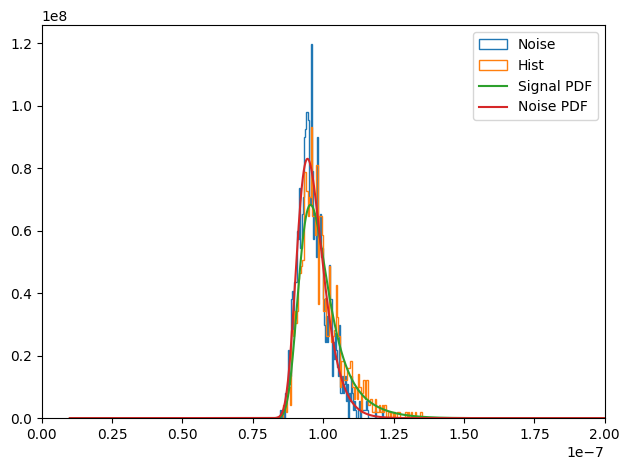

In [91]:
N = 1000
scale_factor = 1


file_ = 'harmonic/90deg/out_0a5a3368-a72b-4392-9ccd-bbcaf9762cbd.h5'

signal_strings, attributes, attrs_container = get_attributes(file_)
signal = get_signal(file_, 'signal1') # One polarisation
signal_FFT = np.fft.fft(signal, norm='forward')

signal_max = np.max(abs(signal_FFT))
signal_max_index = np.argmax(abs(signal_FFT))
complex_signal_max = signal_FFT[signal_max_index]

amplitude_cut = 1e-8

peaks = np.array(signal_FFT[signal_FFT > amplitude_cut])

peak_inds = np.where(signal_FFT > amplitude_cut)


test_noise = rng.multivariate_normal([0,0],np.eye(2)*tau_1f/2, N*Nsamp)
test_noise = test_noise[:,0] + 1j * test_noise[:,1]
test_noise = test_noise.reshape(N, Nsamp)
test_noise_maxima = np.max(abs(test_noise),axis=1)

test_noise[:, peak_inds] += peaks
signal_maxima = np.max(abs(test_noise),axis=1) 

print(peaks)

from scipy import special

y = np.linspace(1e-8, 1e-6, 20001)

rice_cdf = np.ones(20001)
for peak in peaks:
    print(peak)
    rice_cdf *= scipy.stats.rice.cdf(y, abs(peak)/np.sqrt(tau_1f/2), scale=np.sqrt(tau_1f/2))
    
signal_cdf = rice_cdf * ( (1-np.exp(-(y**2)/tau_1f)) ** (Nsamp-peaks.size) )

signal_pdf = np.gradient(signal_cdf, y[1]-y[0])


noise_cdf = (1-np.exp(-(y**2)/tau_1f)) ** Nsamp
noise_pdf = np.gradient(noise_cdf, y[1]-y[0])

plt.figure()
plt.hist(test_noise_maxima, bins=100, density=True, histtype='step', label='Noise')
plt.hist(signal_maxima, bins=100, density=True, histtype='step', label='Hist')

plt.plot(y, signal_pdf, label='Signal PDF')
plt.plot(y, noise_pdf, label='Noise PDF')
plt.legend()

plt.xlim(0, 0.2e-6)
plt.tight_layout()
plt.show()

# y = np.linspace(1e-7, 9e-7, 2001)

In [ ]:

file_ = 'harmonic/86p5deg/out_0aa72c89-416e-4f11-8eda-ae7542078817.h5'

# file_ = 'harmonic/90deg/out_0a5a3368-a72b-4392-9ccd-bbcaf9762cbd.h5'

signal_strings, attributes, attrs_container = get_attributes(file_)
signal = get_signal(file_, 'signal1') # One polarisation
signal_FFT = np.fft.fft(signal, norm='forward')

signal_max = np.max(abs(signal_FFT))
signal_max_index = np.argmax(abs(signal_FFT))
complex_signal_max = signal_FFT[signal_max_index]

print(complex_signal_max)
print(signal_max)
noise = rng.multivariate_normal([0,0],np.eye(2)*tau_1t/2, Nsamp) # Generate a 2d gaussian
noise = noise[:,0] + 1j * noise[:,1]
# noise
# signal

noise_FFT = np.fft.fft(noise, norm='forward')

plt.plot(noise, label='Noise')
plt.plot(signal, label='Signal')

plt.legend()
plt.show();

plt.plot(abs(signal_FFT))
plt.plot(abs(noise_FFT))

(9.609851997553602e-09+3.639786768913486e-08j)
3.764510629192927e-08


In [292]:
fft_summed = np.sum(abs(signal_FFT)**2)
time_summed = np.sum(abs(signal)**2 / Nsamp)

print('Signal Total Power:')
print('FFT:  ',  fft_summed)
print('Time: ', time_summed)

print(fft_summed/time_summed)

print('Ratio of Freq/Time Domain Power', fft_summed/time_summed)

print('####################')

# Same as above but for noise

fft_summed = np.sum(abs(noise_FFT)**2)
time_summed = np.sum(abs(noise)**2/ Nsamp)

print('Noise Total Power:')
print('FFT:  ', fft_summed)
print('Time: ', time_summed)

print('Ratio of Freq/Time Domain Power', fft_summed/time_summed)

Signal Total Power:
FFT:   3.559724264598132e-14
Time:  3.559724264598132e-14
1.0
Ratio of Freq/Time Domain Power 1.0
####################
Noise Total Power:
FFT:   3.4543407139922144e-11
Time:  3.454340713992214e-11
Ratio of Freq/Time Domain Power 1.0000000000000002


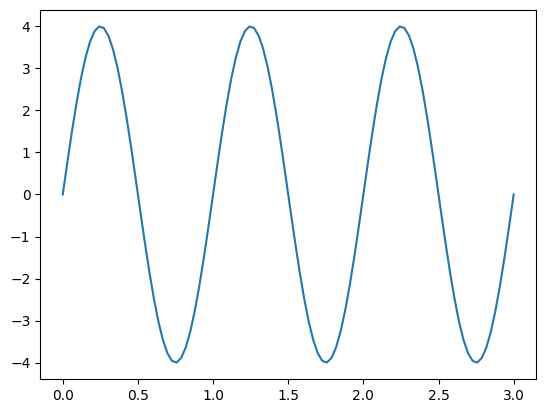

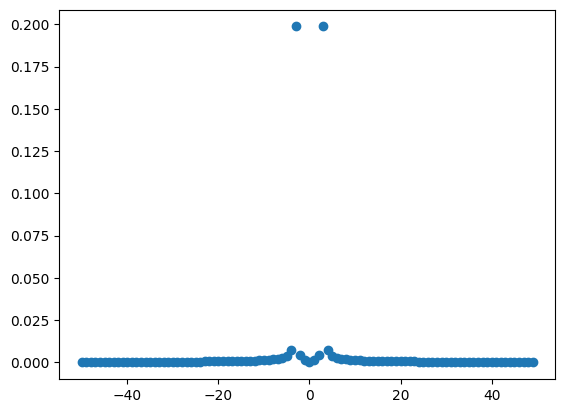

792.0000000000003
791.9999999999999
1.0000000000000004


In [293]:
vals = np.linspace(0, 3, 100)

output = 4 * np.sin(2*np.pi*vals)

plt.plot(vals, output)

sin_fft = np.fft.fft(output, norm='ortho')

plt.figure()
plt.scatter(np.fft.fftfreq(len(sin_fft), 1/100), abs(sin_fft)/len(sin_fft))
plt.show();

print(np.sum(abs(sin_fft)**2))
print(np.sum(abs(output)**2))

print(np.sum(abs(sin_fft)**2 / np.sum(abs(output)**2)))

''

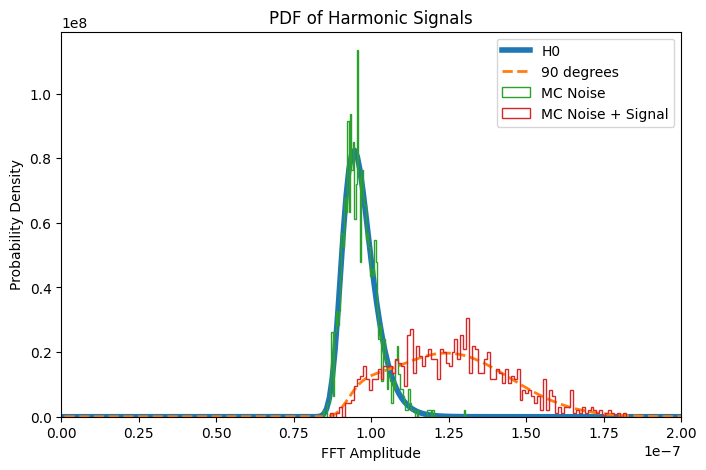

In [97]:
file_list = [
    'harmonic/90deg/out_0a5a3368-a72b-4392-9ccd-bbcaf9762cbd.h5']

harmonic_angles = ['86.5', '87', '87.5', '88', '88.5', '89','89.5', '90']

harmonic_angles = ['90']
# harmonic_angles = ['86.5']

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)

plt.title('PDF of Harmonic Signals')

y = np.linspace(1e-9, 1e-5, 20001)

noise_f = rng.multivariate_normal([0,0],np.eye(2)*tau_1t/2, Nsamp) # Generate a 2d gaussian
noise_f = noise_f[:,0] + 1j * noise_f[:,1]


# H0
ray_cdf = (1-np.exp(-(x**2)/tau_1f)) ** Nsamp
ray_pdf = np.gradient(ray_cdf, x[1]-x[0])

ax.plot(x, ray_pdf, label='H0', lw=4)

for i, file_ in enumerate(file_list):


    signal_strings, attributes, attrs_container = get_attributes(file_)
    signal = get_signal(file_, 'signal1') # One polarisation
    signal_FFT = np.fft.fft(signal, norm='forward')

    signal_max = np.max(abs(signal_FFT))
    signal_max_index = np.argmax(abs(signal_FFT))
    complex_signal_max = signal_FFT[signal_max_index]

    peaks = np.array([complex_signal_max])
    
    peak_inds = np.array([signal_max_index])
    
    validation_noise = rng.multivariate_normal([0,0],np.eye(2)*tau_1f/2, N*Nsamp)
    validation_noise = validation_noise[:,0] + 1j * validation_noise[:,1]
    validation_noise = validation_noise.reshape(N, Nsamp)
    validation_noise_maxima = np.max(abs(validation_noise),axis=1)
    
    validation_noise[:, peak_inds] += peaks
    validation_signal_maxima = np.max(abs(validation_noise),axis=1)
    


    # peak_inds = np.array([50])

    # noise_f[:, peak_inds] += peaks
    # signal_maxima = np.max(abs(lots_of_noise),axis=1) 

    rice_cdf = np.ones(20001)
    for peak in peaks:
        rice_cdf *= scipy.stats.rice.cdf(y, b=abs(peak)/np.sqrt(tau_1f/2), loc=0, scale=np.sqrt(tau_1f/2))
        
    signal_cdf = rice_cdf * (1-np.exp(-(y**2)/tau_1f)) ** (Nsamp-peaks.size)

    signal_pdf = np.gradient(signal_cdf, y[1]-y[0])

    # hist = ax.hist(noise_f, bins=100, density=True, histtype='step', label='Noise Hist' )
    # hist = ax.hist(signal_maxima, bins=100, density=True, histtype='step', label='Hist')

    # linestyles = ['--', '-.', '-', ':', '-.', '--', '-']

    signal_label = str(harmonic_angles[i]) + ' degrees'
    ax.plot(y, signal_pdf, label = signal_label, ls='--', lw=2)

plt.hist(validation_noise_maxima, bins=100, density=True, histtype='step', label='MC Noise')
plt.hist(validation_signal_maxima, bins=100, density=True, histtype='step', label='MC Noise + Signal')

ax.set_xlabel('FFT Amplitude')
ax.set_ylabel('Probability Density')

ax.set_xlim(0.0, 2e-7)

ax.legend()

# plt.savefig('../figures/harmonic_signals_PDF_86p5.pdf', format='pdf', dpi=300)
# plt.savefig('../figures/harmonic_signals_PDF_86p5.png', format='png', dpi=300)

# plt.savefig('../figures/harmonic_signals_PDF.pdf', format='pdf', dpi=300)
# plt.savefig('../figures/harmonic_signals_PDF.png', format='png', dpi=300)
;

# Generating Plots

''

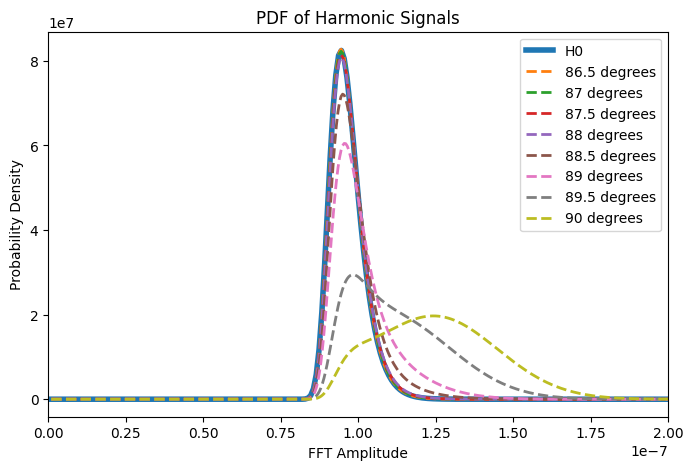

In [94]:
file_list = [
    'harmonic/86p5deg/out_0aa72c89-416e-4f11-8eda-ae7542078817.h5', 
    'harmonic/87deg/out_0a5c4e19-2fc3-4f5c-9090-8d2cce62ae19.h5', 
    'harmonic/87p5deg/out_0c7fdf39-0ea3-4c84-9a9d-60c68b480bb1.h5', 
    'harmonic/88deg/out_0ad74f8f-ec02-44f5-a5af-5c69bef4774e.h5',
    'harmonic/88p5deg/out_0a1bc7f8-6e25-47f3-9743-f404227c3d0b.h5',
    'harmonic/89deg/out_1a0ad631-1153-47ef-8cba-ea9ab0cefa3d.h5',
    'harmonic/89p5deg/out_51db499d-c8ea-4cce-884b-d9c3e3f44ed1.h5',
    'harmonic/90deg/out_0a5a3368-a72b-4392-9ccd-bbcaf9762cbd.h5']

harmonic_angles = ['86.5', '87', '87.5', '88', '88.5', '89','89.5', '90']

# harmonic_angles = ['90']
# harmonic_angles = ['86.5']

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)

plt.title('PDF of Harmonic Signals')

y = np.linspace(1e-9, 1e-5, 20001)

noise_f = rng.multivariate_normal([0,0],np.eye(2)*tau_1t/2, Nsamp) # Generate a 2d gaussian
noise_f = noise_f[:,0] + 1j * noise_f[:,1]


# H0
ray_cdf = (1-np.exp(-(x**2)/tau_1f)) ** Nsamp
ray_pdf = np.gradient(ray_cdf, x[1]-x[0])

ax.plot(x, ray_pdf, label='H0', lw=4)

for i, file_ in enumerate(file_list):


    signal_strings, attributes, attrs_container = get_attributes(file_)
    signal = get_signal(file_, 'signal1') # One polarisation
    signal_FFT = np.fft.fft(signal, norm='forward')

    signal_max = np.max(abs(signal_FFT))
    signal_max_index = np.argmax(abs(signal_FFT))
    complex_signal_max = signal_FFT[signal_max_index]


    peaks = np.array([complex_signal_max])


    # peak_inds = np.array([50])

    # noise_f[:, peak_inds] += peaks
    # signal_maxima = np.max(abs(lots_of_noise),axis=1) 

    rice_cdf = np.ones(20001)
    for peak in peaks:
        rice_cdf *= scipy.stats.rice.cdf(y, b=abs(peak)/np.sqrt(tau_1f/2), loc=0, scale=np.sqrt(tau_1f/2))
        
    signal_cdf = rice_cdf * (1-np.exp(-(y**2)/tau_1f)) ** (Nsamp-peaks.size)

    signal_pdf = np.gradient(signal_cdf, y[1]-y[0])

    # hist = ax.hist(noise_f, bins=100, density=True, histtype='step', label='Noise Hist' )
    # hist = ax.hist(signal_maxima, bins=100, density=True, histtype='step', label='Hist')

    # linestyles = ['--', '-.', '-', ':', '-.', '--', '-']

    signal_label = str(harmonic_angles[i]) + ' degrees'
    ax.plot(y, signal_pdf, label = signal_label, ls='--', lw=2)

ax.set_xlabel('FFT Amplitude')
ax.set_ylabel('Probability Density')

ax.set_xlim(0.0, 2e-7)

ax.legend()

# plt.savefig('../figures/harmonic_signals_PDF_86p5.pdf', format='pdf', dpi=300)
# plt.savefig('../figures/harmonic_signals_PDF_86p5.png', format='png', dpi=300)

# plt.savefig('../figures/harmonic_signals_PDF.pdf', format='pdf', dpi=300)
# plt.savefig('../figures/harmonic_signals_PDF.png', format='png', dpi=300)
;

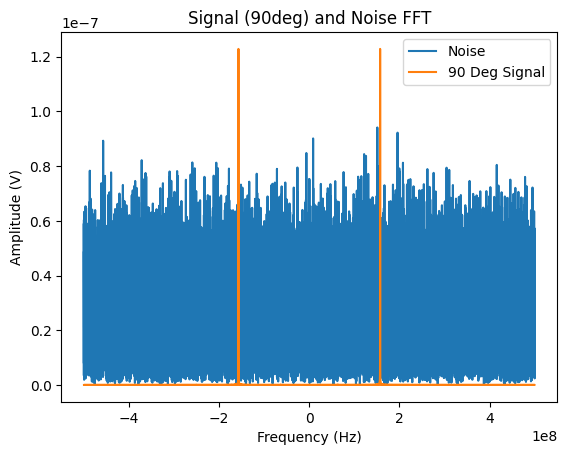

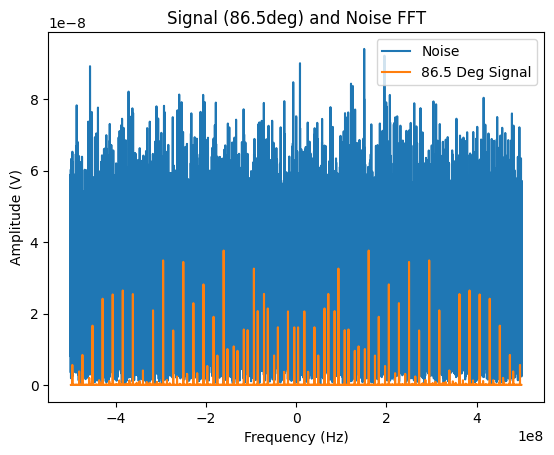

In [295]:
signal_strings, attributes, attrs_container = get_attributes(file_)
signal = get_signal(file_, 'signal1') # One polarisation
signal_FFT = np.fft.fft(signal, norm='forward')

signal_max = np.max(abs(signal_FFT))
signal_max_index = np.argmax(abs(signal_FFT))
complex_signal_max = signal_FFT[signal_max_index]


fft_freqs = np.fft.fftfreq(Nsamp, 1e-9)

plt.figure()
plt.title('Signal (90deg) and Noise FFT')
plt.plot(fft_freqs, abs(noise_1f), label='Noise')
plt.plot(fft_freqs, abs(signal_FFT), label='90 Deg Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (V)')
plt.legend()
plt.savefig('../figures/90deg_signal_noise_fft.pdf', format='pdf', dpi=300)
plt.savefig('../figures/90deg_signal_noise_fft.png', format='png', dpi=300)
plt.show()

file_86p5 = 'harmonic/86p5deg/out_0aa72c89-416e-4f11-8eda-ae7542078817.h5'

signal_strings, attributes, attrs_container = get_attributes(file_86p5)
signal = get_signal(file_86p5, 'signal1') # One polarisation
signal_FFT = np.fft.fft(signal, norm='forward')

signal_max = np.max(abs(signal_FFT))
signal_max_index = np.argmax(abs(signal_FFT))
complex_signal_max = signal_FFT[signal_max_index]

plt.figure()
plt.title('Signal (86.5deg) and Noise FFT')
plt.plot(fft_freqs, abs(noise_1f), label='Noise')
plt.plot(fft_freqs, abs(signal_FFT), label='86.5 Deg Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (V)')
plt.legend()
# plt.savefig('../figures/86p5deg_signal_noise_fft.pdf', format='pdf', dpi=300)
# plt.savefig('../figures/86p5deg_signal_noise_fft.png', format='png', dpi=300)
plt.show()


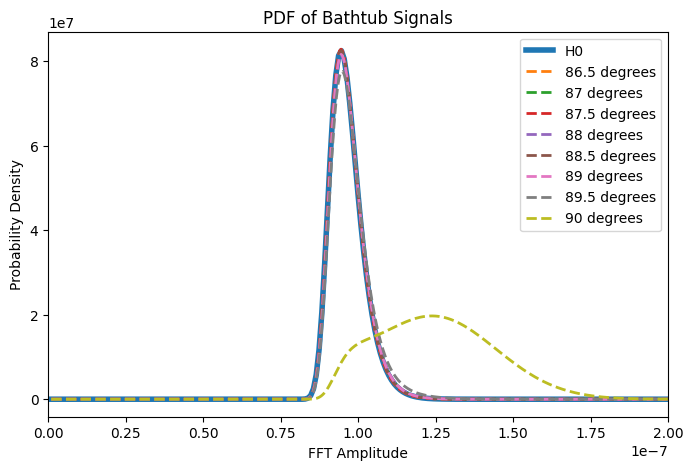

In [297]:
data_paths = '../data/bathtub/**/*.h5'
file_list_bath = [
 'bathtub/86p5deg/out_0d096f21-981a-468e-aaac-00bcc351c1fe.h5',
 'bathtub/87deg/out_0a12956a-3496-409c-88a8-6f4772eb1f88.h5',
 'bathtub/87p5deg/out_0ebb2189-221e-4e65-8b26-cd7f0b39368e.h5',
 'bathtub/88deg/out_0a3e80ad-1d5a-4d21-9704-6e50e240fdea.h5',
 'bathtub/88p5deg/out_0a2fa0ce-10be-4457-b781-1d4d961582d0.h5',
 'bathtub/89deg/out_0d737c3e-146a-4958-9dff-3d101f342b46.h5',
 'bathtub/89p5deg/out_0f47865a-b68b-4e22-a86e-ba100b152012.h5',
 'bathtub/90deg/out_0af13536-3a60-4a74-b42c-3c85aabfa86c.h5'
 ]

bath_angles = ['86.5', '87', '87.5', '88', '88.5', '89', '89.5', '90']

# bath_angles = ['90']

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)

plt.title('PDF of Bathtub Signals')

y = np.linspace(1e-9, 1e-5, 20001)

noise_f = rng.multivariate_normal([0,0],np.eye(2)*tau_1t/2, Nsamp) # Generate a 2d gaussian
noise_f = noise_f[:,0] + 1j * noise_f[:,1]


# H0
ray_cdf = (1-np.exp(-(x**2)/tau_1f)) ** Nsamp
ray_pdf = np.gradient(ray_cdf, x[1]-x[0])

ax.plot(x, ray_pdf, label='H0', lw=4)

for i, file_ in enumerate(file_list_bath):

    signal_strings, attributes, attrs_container = get_attributes(file_)
    signal = get_signal(file_, 'signal1') # One polarisation
    signal_FFT = np.fft.fft(signal, norm='forward')

    signal_max = np.max(abs(signal_FFT))
    signal_max_index = np.argmax(abs(signal_FFT))
    complex_signal_max = signal_FFT[signal_max_index]


    peaks = np.array([complex_signal_max])


    # peak_inds = np.array([50])

    # noise_f[:, peak_inds] += peaks
    # signal_maxima = np.max(abs(lots_of_noise),axis=1) 

    rice_cdf = np.ones(20001)
    for peak in peaks:
        rice_cdf *= scipy.stats.rice.cdf(y, b=abs(peak)/np.sqrt(tau_1f/2), loc=0, scale=np.sqrt(tau_1f/2))
        
    signal_cdf = rice_cdf * (1-np.exp(-(y**2)/tau_1f)) ** (Nsamp-peaks.size)

    signal_pdf = np.gradient(signal_cdf, y[1]-y[0])

    # hist = ax.hist(noise_f, bins=100, density=True, histtype='step', label='Noise Hist' )
    # hist = ax.hist(signal_maxima, bins=100, density=True, histtype='step', label='Hist')

    signal_label = str(bath_angles[i]) + ' degrees'
    ax.plot(y, signal_pdf, label = signal_label, ls='--', lw=2)

ax.set_xlabel('FFT Amplitude')
ax.set_ylabel('Probability Density')

ax.set_xlim(0.0, 2e-7)



ax.legend()

# plt.savefig('../figures/bathtubs_signals_PDF_90.pdf', format='pdf', dpi=300)
# plt.savefig('../figures/bathtubs_signals_PDF_90.png', format='png', dpi=300)

# plt.savefig('../figures/bathtubs_signals_PDF.pdf', format='pdf', dpi=300)
# plt.savefig('../figures/bathtubs_signals_PDF.png', format='png', dpi=300);

In [298]:
get_attributes(file_list[4])


(['signal1', 'signal2'],
 ['B_bkg [Tesla]',
  'Cyclotron frequency [Hertz]',
  'Downmixed cyclotron frequency [Hertz]',
  'Energy [eV]',
  'LO frequency [Hertz]',
  'Pitch angle [degrees]',
  'Starting position [metres]',
  'Starting velocity [metres/second]',
  'Time step [seconds]',
  'Waveguide impedance [Ohms]',
  'i_coil [Amps]',
  'r_coil [metres]',
  'r_wg [metres]'],
 [[0.7033999999999999,
   18913125525.08392,
   163839202.8963852,
   18575.0,
   18749286322.187534,
   88.5,
   array([-0.00121945,  0.00182482,  0.        ]),
   array([-61376853.74596464,  49222946.6185405 ,  -2060220.81826565]),
   1e-09,
   595.1528721578018,
   108.22536124357357,
   0.02,
   0.006],
  [0.7033999999999999,
   18913125525.08392,
   0.0,
   18575.0,
   18749286322.187534,
   88.5,
   array([-0.00121945,  0.00182482,  0.        ]),
   array([-61376853.74596464,  49222946.6185405 ,  -2060220.81826565]),
   1e-09,
   595.1528721578018,
   108.22536124357357,
   0.02,
   0.006]])

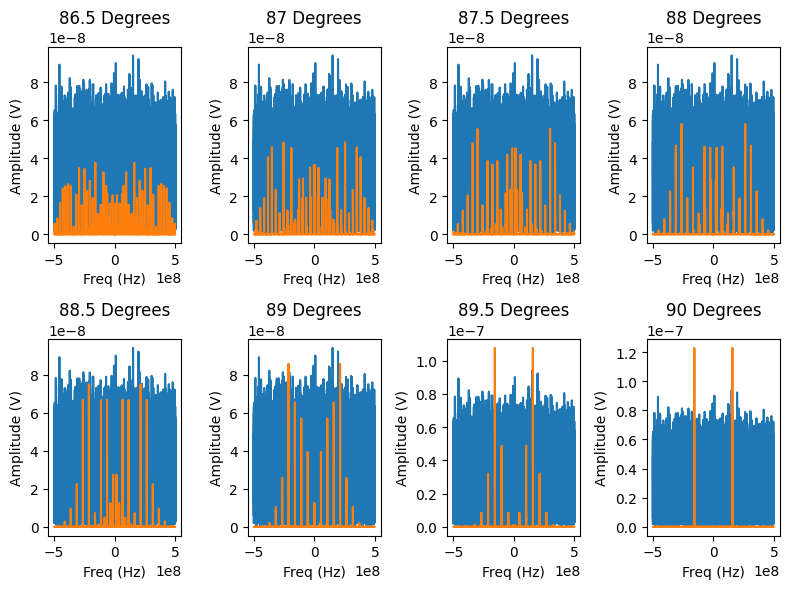

In [299]:
file_list = [
    'harmonic/86p5deg/out_0aa72c89-416e-4f11-8eda-ae7542078817.h5', 
    'harmonic/87deg/out_0a5c4e19-2fc3-4f5c-9090-8d2cce62ae19.h5', 
    'harmonic/87p5deg/out_0c7fdf39-0ea3-4c84-9a9d-60c68b480bb1.h5', 
    'harmonic/88deg/out_0ad74f8f-ec02-44f5-a5af-5c69bef4774e.h5',
    'harmonic/88p5deg/out_0a1bc7f8-6e25-47f3-9743-f404227c3d0b.h5',
    'harmonic/89deg/out_1a0ad631-1153-47ef-8cba-ea9ab0cefa3d.h5',
    'harmonic/89p5deg/out_51db499d-c8ea-4cce-884b-d9c3e3f44ed1.h5',
    'harmonic/90deg/out_0a5a3368-a72b-4392-9ccd-bbcaf9762cbd.h5']

harmonic_angles = ['86.5', '87', '87.5', '88', '88.5', '89','89.5', '90']

fig, axs = plt.subplots(2, 4, figsize=(8,6))


for i, file_ in enumerate(file_list):

    signal_strings, attributes, attrs_container = get_attributes(file_)
    signal = get_signal(file_, 'signal1') # One polarisation
    signal_FFT = np.fft.fft(signal, norm='forward')

    signal_max = np.max(abs(signal_FFT))
    signal_max_index = np.argmax(abs(signal_FFT))
    complex_signal_max = signal_FFT[signal_max_index]

    axs[i//4, i%4].set_title(harmonic_angles[i] + ' Degrees')
    axs[i//4, i%4].plot(fft_freqs, abs(noise_1f), label='Noise')
    axs[i//4, i%4].plot(fft_freqs, abs(signal_FFT), label=harmonic_angles[i] + ' Deg Signal')
    axs[i//4, i%4].set_xlabel('Freq (Hz)')
    axs[i//4, i%4].set_ylabel('Amplitude (V)')
    
plt.tight_layout()

plt.savefig('../figures/harmonic_signals_fft.pdf', format='pdf', dpi=300)
plt.savefig('../figures/harmonic_signals_fft.png', format='png', dpi=300)

plt.show();


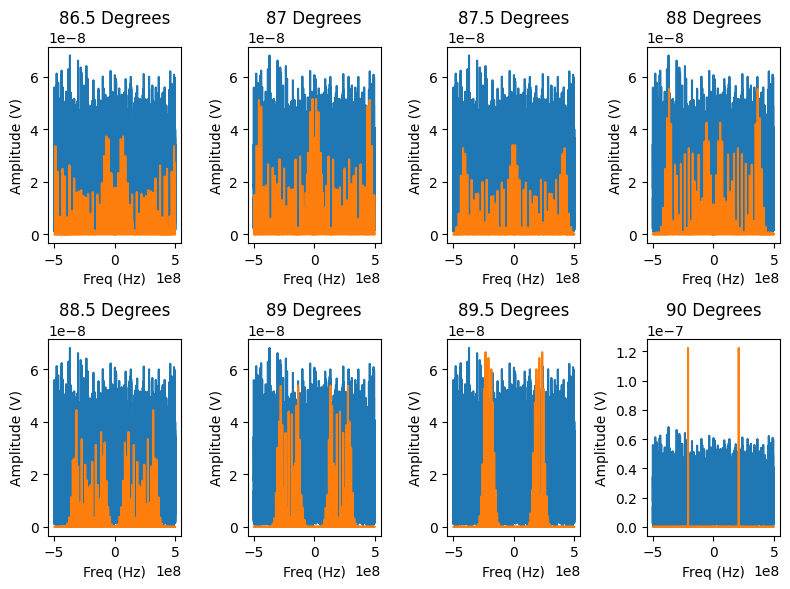

In [242]:
file_list_bath = [
 'bathtub/86p5deg/out_0d096f21-981a-468e-aaac-00bcc351c1fe.h5',
 'bathtub/87deg/out_0a12956a-3496-409c-88a8-6f4772eb1f88.h5',
 'bathtub/87p5deg/out_0ebb2189-221e-4e65-8b26-cd7f0b39368e.h5',
 'bathtub/88deg/out_0a3e80ad-1d5a-4d21-9704-6e50e240fdea.h5',
 'bathtub/88p5deg/out_0a2fa0ce-10be-4457-b781-1d4d961582d0.h5',
 'bathtub/89deg/out_0d737c3e-146a-4958-9dff-3d101f342b46.h5',
 'bathtub/89p5deg/out_0f47865a-b68b-4e22-a86e-ba100b152012.h5',
 'bathtub/90deg/out_0af13536-3a60-4a74-b42c-3c85aabfa86c.h5'
 ]

harmonic_angles = ['86.5', '87', '87.5', '88', '88.5', '89','89.5', '90']

fig, axs = plt.subplots(2, 4, figsize=(8,6))


for i, file_ in enumerate(file_list_bath):

    signal_strings, attributes, attrs_container = get_attributes(file_)
    signal = get_signal(file_, 'signal1') # One polarisation
    signal_FFT = np.fft.fft(signal, norm='forward')

    signal_max = np.max(abs(signal_FFT))
    signal_max_index = np.argmax(abs(signal_FFT))
    complex_signal_max = signal_FFT[signal_max_index]

    axs[i//4, i%4].set_title(harmonic_angles[i] + ' Degrees')
    axs[i//4, i%4].plot(fft_freqs, abs(noise_1f), label='Noise')
    axs[i//4, i%4].plot(fft_freqs, abs(signal_FFT), label=harmonic_angles[i] + ' Deg Signal')
    axs[i//4, i%4].set_xlabel('Freq (Hz)')
    axs[i//4, i%4].set_ylabel('Amplitude (V)')
    
plt.tight_layout()

plt.savefig('../figures/bathtub_signals_fft.pdf', format='pdf', dpi=300)
plt.savefig('../figures/bathtub_signals_fft.png', format='png', dpi=300)

plt.show();


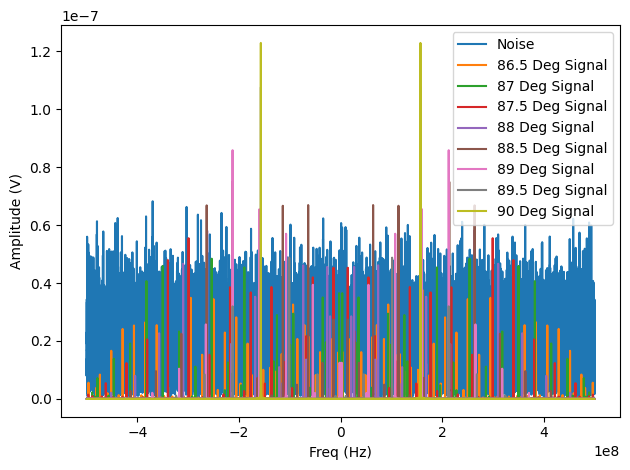

In [247]:
file_list = [
    'harmonic/86p5deg/out_0aa72c89-416e-4f11-8eda-ae7542078817.h5', 
    'harmonic/87deg/out_0a5c4e19-2fc3-4f5c-9090-8d2cce62ae19.h5', 
    'harmonic/87p5deg/out_0c7fdf39-0ea3-4c84-9a9d-60c68b480bb1.h5', 
    'harmonic/88deg/out_0ad74f8f-ec02-44f5-a5af-5c69bef4774e.h5',
    'harmonic/88p5deg/out_0a1bc7f8-6e25-47f3-9743-f404227c3d0b.h5',
    'harmonic/89deg/out_1a0ad631-1153-47ef-8cba-ea9ab0cefa3d.h5',
    'harmonic/89p5deg/out_51db499d-c8ea-4cce-884b-d9c3e3f44ed1.h5',
    'harmonic/90deg/out_0a5a3368-a72b-4392-9ccd-bbcaf9762cbd.h5']

harmonic_angles = ['86.5', '87', '87.5', '88', '88.5', '89','89.5', '90']

plt.figure()

plt.plot(fft_freqs, abs(noise_1f), label='Noise')

for i, file_ in enumerate(file_list):

    signal_strings, attributes, attrs_container = get_attributes(file_)
    signal = get_signal(file_, 'signal1') # One polarisation
    signal_FFT = np.fft.fft(signal, norm='forward')

    signal_max = np.max(abs(signal_FFT))
    signal_max_index = np.argmax(abs(signal_FFT))
    complex_signal_max = signal_FFT[signal_max_index]


    plt.plot(fft_freqs, abs(signal_FFT), label=harmonic_angles[i] + ' Deg Signal')
    
plt.xlabel('Freq (Hz)')
plt.ylabel('Amplitude (V)')
    
plt.legend()
plt.tight_layout()

plt.savefig('../figures/all_harmonic_signals_fft.pdf', format='pdf', dpi=300)
plt.savefig('../figures/all_harmonic_signals_fft.png', format='png', dpi=300)

plt.show();


Testing Multiple Bins 

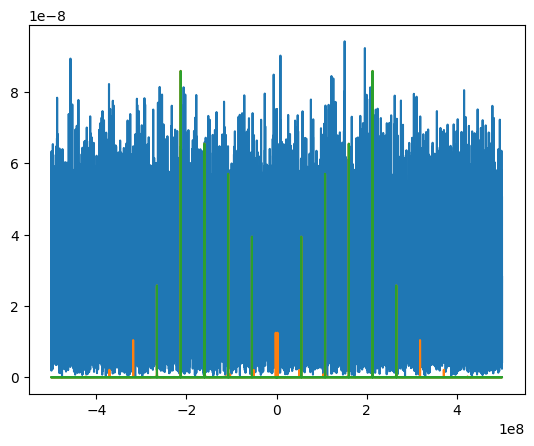

In [321]:
test_file = 'harmonic/89deg/out_1a0ad631-1153-47ef-8cba-ea9ab0cefa3d.h5'


signal_strings, attributes, attrs_container = get_attributes(test_file)
signal = get_signal(test_file, 'signal1') # One polarisation
signal_FFT = np.fft.fft(signal, norm='forward')

signal_max = np.max(abs(signal_FFT))
signal_max_index = np.argmax(abs(signal_FFT))
complex_signal_max = signal_FFT[signal_max_index]

plt.plot(fft_freqs, abs(noise_1f), label='Noise')
plt.plot(fft_freqs, abs(signal_FFT), label='86.5 Deg Signal');

cut_value = 2e-8

cut_fft = abs(signal_FFT)[abs(signal_FFT) > cut_value]

signal_fft_copy = np.copy(signal_FFT)

signal_fft_copy[abs(signal_FFT) < cut_value] = 0

plt.plot(fft_freqs, abs(signal_fft_copy))

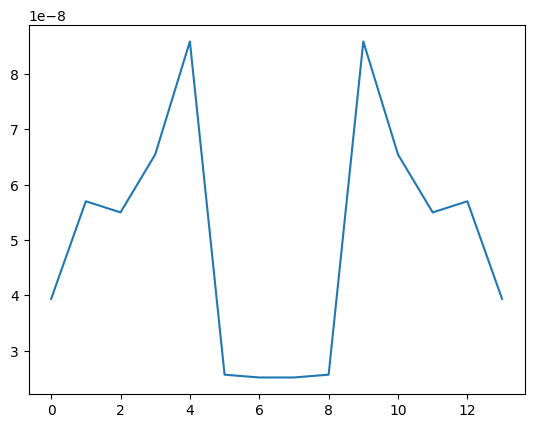

In [322]:
plt.plot(cut_fft)

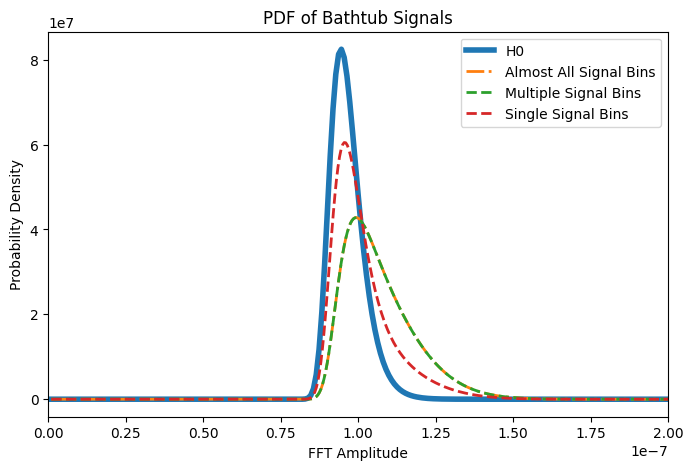

In [327]:
bath_angles = ['86.5']

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)

plt.title('PDF of Bathtub Signals')

y = np.linspace(1e-9, 1e-5, 20001)

noise_f = rng.multivariate_normal([0,0],np.eye(2)*tau_1t/2, Nsamp) # Generate a 2d gaussian
noise_f = noise_f[:,0] + 1j * noise_f[:,1]


# H0
ray_cdf = (1-np.exp(-(x**2)/tau_1f)) ** Nsamp
ray_pdf = np.gradient(ray_cdf, x[1]-x[0])

ax.plot(x, ray_pdf, label='H0', lw=4)


#####

peaks = np.array(signal_FFT)

cut2_fft = abs(signal_FFT)[abs(signal_FFT) > 1e-9]

peaks = np.array(cut2_fft)

rice_cdf = np.ones(20001)
for peak in peaks:
    rice_cdf *= scipy.stats.rice.cdf(y, b=abs(peak)/np.sqrt(tau_1f/2), loc=0, scale=np.sqrt(tau_1f/2))
    
signal_cdf = rice_cdf * (1-np.exp(-(y**2)/tau_1f)) ** (Nsamp-peaks.size)

signal_pdf = np.gradient(signal_cdf, y[1]-y[0])


signal_label = str(bath_angles) + ' degrees'
ax.plot(y, signal_pdf, label = 'Almost All Signal Bins', ls='-.', lw=2)



#####



peaks = np.array(cut_fft)

rice_cdf = np.ones(20001)
for peak in peaks:
    rice_cdf *= scipy.stats.rice.cdf(y, b=abs(peak)/np.sqrt(tau_1f/2), loc=0, scale=np.sqrt(tau_1f/2))
    
signal_cdf = rice_cdf * (1-np.exp(-(y**2)/tau_1f)) ** (Nsamp-peaks.size)

signal_pdf = np.gradient(signal_cdf, y[1]-y[0])


signal_label = str(bath_angles) + ' degrees'
ax.plot(y, signal_pdf, label = 'Multiple Signal Bins', ls='--', lw=2)
 
test_file = 'harmonic/89deg/out_1a0ad631-1153-47ef-8cba-ea9ab0cefa3d.h5'


signal_strings, attributes, attrs_container = get_attributes(test_file)
signal = get_signal(test_file, 'signal1') # One polarisation
signal_FFT = np.fft.fft(signal, norm='forward')

signal_max = np.max(abs(signal_FFT))
signal_max_index = np.argmax(abs(signal_FFT))
complex_signal_max = signal_FFT[signal_max_index]

peaks = np.array([complex_signal_max])


rice_cdf = np.ones(20001)
for peak in peaks:
    rice_cdf *= scipy.stats.rice.cdf(y, b=abs(peak)/np.sqrt(tau_1f/2), loc=0, scale=np.sqrt(tau_1f/2))
    
signal_cdf = rice_cdf * (1-np.exp(-(y**2)/tau_1f)) ** (Nsamp-peaks.size)

signal_pdf = np.gradient(signal_cdf, y[1]-y[0])

ax.plot(y, signal_pdf, label = 'Single Signal Bins', ls='--', lw=2)



ax.set_xlabel('FFT Amplitude')
ax.set_ylabel('Probability Density')

ax.set_xlim(0.0, 2e-7)



ax.legend()

# plt.savefig('../figures/bathtubs_signals_PDF_90.pdf', format='pdf', dpi=300)
# plt.savefig('../figures/bathtubs_signals_PDF_90.png', format='png', dpi=300)

# plt.savefig('../figures/bathtubs_signals_PDF.pdf', format='pdf', dpi=300)
# plt.savefig('../figures/bathtubs_signals_PDF.png', format='png', dpi=300);

In [318]:
peaks= (cut_fft)

In [319]:
for peak in peaks:
    print(peak)

2.059858450544825e-08
2.1424314190503257e-08
2.5490234720384254e-08
2.0693638947571172e-08
3.258499888711934e-08
3.764510629192927e-08
2.8164151194056785e-08
2.2913074711427924e-08
3.44467757733729e-08
3.4883554113329375e-08
2.010174108413321e-08
2.0892001764697923e-08
2.5457702703415116e-08
2.6461563481779184e-08
2.5350450441050443e-08
2.414958382336652e-08
2.414958382336652e-08
2.5350450441050443e-08
2.6461563481779187e-08
2.5457702703415116e-08
2.089200176469792e-08
2.010174108413321e-08
3.4883554113329375e-08
3.44467757733729e-08
2.291307471142792e-08
2.8164151194056785e-08
3.764510629192927e-08
3.258499888711934e-08
2.0693638947571176e-08
2.5490234720384254e-08
2.1424314190503253e-08
2.059858450544825e-08



### Checks
Generating Noise Time Domain and making sure everything matches up

Check PDFs using Monte Carlo methods, pick one event and run lots of noise samples, take max value, plot histogram

## Analysis
Efficiency of detection over electron position
Over Pitch angle

In the end we want a ROC curve

# Write this up

## Exploration 
- Varying the noise temperature
- Varying the trapping configuration
- Beam of trititum change

# Loop around
- Wrap up Hough + DBSCAN

# Further
- Template bank
- Flow chart